# Example analysis of a PPG waveform using the vital_sqi package

The following notebook shows an example of PPG waveform processing using the vital_sqi package. The aim of the package is to automate signal quality classification for PPG waveforms. It is achieved by computing various signal quality indices for each signal segment and using them to form a decision. 

## The pipeline can be briefly summarized as follows:
1. Load dataset under analysis
2. Preprocess and segment the dataset
3. Compute SQI for each dataset segment
4. Make decision for each segment

## Global Imports

In [1]:
import numpy as np
import warnings
import pandas as pd 
import matplotlib.pyplot as plt
import vital_sqi

### Start by importing the signal via the PPG_reader function

The function expects a .csv or similar data format with named columns. The column names are used to separate between data column, timestamp columns and any additional information columns.
This returns a SignalSQI class that is compatible with other vital_sqi package functions, the main class members of interest are:
* signals:         an ndarray of shape (m, n) where m is the number of rows and n is the number of channels of the signal
* sqi_indexes:     an ndarray of shape (m, n) where m is the number of signal segments, n is the number of SQIs.
* sampling_rate:   sampling rate in hertz (Hz)


                          idx  PLETH
timedelta                           
0 days 00:00:00             0  51399
0 days 00:00:00.010000      1  50011
0 days 00:00:00.020000      2  48555
0 days 00:00:00.030000      3  47298
0 days 00:00:00.040000      4  46175
...                       ...    ...
0 days 00:03:59.930000  23993  17670
0 days 00:03:59.940000  23994  16573
0 days 00:03:59.950000  23995  15475
0 days 00:03:59.960000  23996  14312
0 days 00:03:59.970000  23997  13214

[23998 rows x 2 columns]


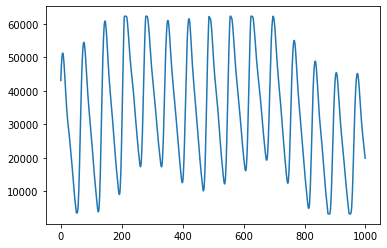

In [2]:
from vital_sqi.data.signal_io import PPG_reader

#Prepare variables for analysis
sampling_rate = 100 #Hz
hp_filt_params = (1, 1) #(Hz, order)
lp_filt_params = (20, 4) #(Hz, order)
filter_type =  'butter'
trim_amount = 20 #s
segment_length = 10 #s

file_name = "ppg_smartcare.csv"
ppg_data = PPG_reader(os.path.join("../tests/test_data",file_name),
                      signal_idx=['PLETH'],
                      timestamp_idx= ['TIMESTAMP_MS'],
                      info_idx=['SPO2_PCT','PULSE_BPM','PERFUSION_INDEX'], 
                      timestamp_unit='ms', sampling_rate=sampling_rate, start_datetime=None)

#We have loaded a single data column, therefore we only have 1D timeseries
print(ppg_data.signals)
#Plot a random 10s segment of the signal
s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, ppg_data.signals['PLETH'][4000:5000])
plt.show()

### Filter each signal channel by a band pass filter and trim

The filter_preprocess function applies two digital filters in succession. First high-pass filter followed by a low-pass. The touples used as function parameters stand for cutoff frequency and filter order respectively. Finally, a plot in this example shows the filtered signal centered around 0 as expected.

In [5]:
import vital_sqi.highlevel_functions.highlevel as sqi_hl

sqis = sqi_hl.compute_SQI(ppg_data.signals, '30s', 7, 6, ppg_data.wave_type, ppg_data.sampling_rate, 1)
print(sqis)



ppg
c:\Users\skaro\OneDrive - Imperial College London\PhD\Python_envs\vital_sqi_env\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
c:\Users\skaro\OneDrive - Imperial College London\PhD\Python_envs\vital_sqi_env\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
c:\Users\skaro\OneDrive - Imperial College London\PhD\Python_envs\vital_sqi_env\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
c:\Users\skaro\OneDrive - Imperial College London\PhD\Python_envs\vital_sqi_env\lib\sit

### Example peak detection on one segment
Using the Billauer peak detector we can illustrate the output of the peak detector

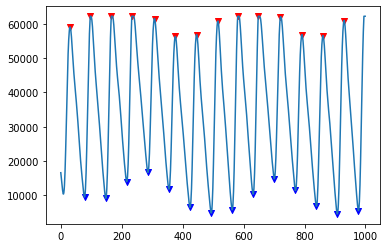

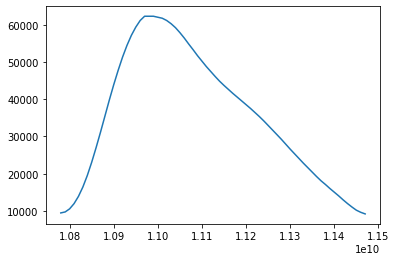

In [4]:
from vital_sqi.common.rpeak_detection import PeakDetector

detector = PeakDetector()
signal_seg = ppg_data.signals['PLETH'][1000:2000]
peak_list, trough_list = detector.ppg_detector(signal_seg, 7)

#Plot results of peak detection
s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, signal_seg)
if len(peak_list)!=0:
    ax.scatter(peak_list,signal_seg[peak_list],color="r",marker="v")
if len(trough_list)!=0:
    ax.scatter(trough_list,signal_seg[trough_list],color="b",marker="v")
plt.show()
warnings.filterwarnings("ignore")
#Plot a single period
fig, ax = plt.subplots()
ax.plot(signal_seg[trough_list[0]:trough_list[1]])
plt.show()